In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# 1. Carregar o dataset Fashion-MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizar os valores dos pixels para o intervalo [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Expandir dimensão para corresponder ao formato esperado (altura, largura, canais)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Limitar o número de imagens para extração de características
train_limit = 1000
test_limit = 1000
train_images = train_images[:train_limit]
train_labels = train_labels[:train_limit]
test_images = test_images[:test_limit]
test_labels = test_labels[:test_limit]

# Definir tamanho das imagens para MobileNetV2
IMG_SIZE = 96

In [4]:
# Função para redimensionar imagens e converter para 3 canais (RGB)
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.grayscale_to_rgb(image)
    return image, label

# Criar datasets eficientes com tf.data
batch_size = 32  # O batch size define quantas imagens serão processadas de uma vez. Um valor maior acelera o treinamento, mas consome mais memória RAM.
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Aplicar a função de preprocessamento sob demanda
train_dataset = train_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
# 2. Carregar MobileNetV2 pré-treinado sem a camada de classificação
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Congelar os pesos do modelo base

# Criar modelo para extração de características
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
outputs = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# 3. Extrair características das imagens de treino e teste
train_features = np.concatenate([feature_extractor.predict(batch[0]) for batch in train_dataset])
test_features = np.concatenate([feature_extractor.predict(batch[0]) for batch in test_dataset])

# 4. Calcular similaridade usando similaridade do cosseno
similarities = cosine_similarity(test_features, train_features)

# Função para obter recomendações
def get_recommendations(image_index, num_recommendations=5):
    nearest_indices = np.argsort(-similarities[image_index])[:num_recommendations]
    return nearest_indices

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [7]:
# 5. Visualizar recomendações
def plot_recommendations(test_image, recommended_indices):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, len(recommended_indices) + 1, 1)
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.title("Imagem de Entrada")
    plt.axis('off')

    for i, idx in enumerate(recommended_indices):
        plt.subplot(1, len(recommended_indices) + 1, i + 2)
        plt.imshow(train_images[idx].squeeze(), cmap='gray')
        plt.title(f"Recomendação {i + 1}")
        plt.axis('off')
    plt.show()

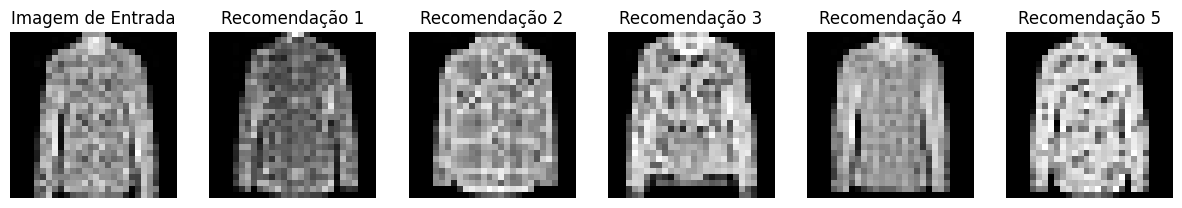

Média da Similaridade: 0.4972


In [9]:
# Exemplo: obter 5 recomendações para uma imagem de teste
image_index = 101  # Alterar para testar outras imagens
recommended_indices = get_recommendations(image_index, 5)
plot_recommendations(test_images[image_index], recommended_indices)

# 6. Avaliação do modelo
def evaluate_model():
    mean_similarity = np.mean(similarities)
    print(f'Média da Similaridade: {mean_similarity:.4f}')

evaluate_model()